## Import Library

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
import pandas as pd   # data analysis
import numpy as np    # numerical analysis
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.stats.anova import anova_lm
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score
)
# --- Install ISLP if missing ---
try:
    import ISLP
except ImportError:
    !pip install ISLP
    import ISLP

from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly
# --- Google Colab setup ---
from google.colab import drive
drive.mount('/content/drive')

# Show all columns & rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option("display.max_info_columns", 999)

dir = '/content/drive/MyDrive/Colab Notebooks/BUS 310/Data'
print("Files in data directory:", os.listdir(dir))
data_path = os.path.join(dir, 'p2p_lending.csv')
df_raw = pd.read_csv(data_path)  # keep raw for EDA
df = df_raw.copy()               # working df for regression

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 6.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=45b16c6c736d4b11f24f2cd0e460a21894c264335848dfc8b720aed8eac4b8dd
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in data directory: ['Advertising.csv', '

/tmp/ipython-input-1672046789.py:45: DtypeWarning: Columns (45,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(data_path)  # keep raw for EDA


##1) Data Pre-processing

In [ ]:
df.head(5)

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,66624733,18000,18000,18000.0,60 months,19.48,471.70,E,E2,Software Manager,7 years,RENT,150000.0,Not Verified,Dec-15,Charged Off,n,debt_consolidation,Debt consolidation,916xx,CA,9.39,0,Jun-05,665,669,1,NaN,18,1,14052,40.7,27,w,0.0,0.0,9452.74,9452.74,3481.86,4351.98,0.00,1618.90,291.4020,May-17,471.70,NaN,Nov-17,584,580,0,NaN,1,Individual,NaN,NaN,NaN,0,60,36247,2.0,2.0,1.0,3.0,2.0,22195.0,71.0,2.0,4.0,1271.0,55.0,34500,2.0,1.0,2.0,7,2014.0,5128.0,51.3,0,0,115.0,112,1,1,2,9.0,NaN,2.0,NaN,0,6,13,7,8,6,16,19.0,13,18,0.0,0,0,3,100.0,14.3,1,0,65819,36247,10300,31319,N,Cash,N
1,67849662,4225,4225,4225.0,36 months,14.85,146.16,C,C5,mechanic,5 years,RENT,35000.0,Source Verified,Dec-15,Charged Off,n,debt_consolidation,Debt consolidation,672xx,KS,15.22,2,Jul-11,725,729,0,18.0,6,0,1058,24.6,6,w,0.0,0.0,2558.87,2558.87,1536.90,653.60,0.00,368.37,66.3066,Apr-17,146.16,NaN,Dec-17,499,0,0,NaN,1,Individual,NaN,NaN,NaN,0,0,4888,0.0,1.0,0.0,0.0,47.0,3830.0,22.0,0.0,0.0,367.0,22.0,4300,0.0,0.0,0.0,0,815.0,2233.0,14.1,0,0,47.0,53,26,26,0,26.0,NaN,14.0,18.0,0,1,2,3,3,1,5,5.0,2,6,0.0,0,0,0,66.7,0.0,0,0,21822,4888,2600,17522,N,Cash,N
2,67715283,16000,16000,16000.0,36 months,12.88,538.18,C,C2,"Owner, Fee Appraiser",10+ years,MORTGAGE,65000.0,Not Verified,Dec-15,Charged Off,n,small_business,Business,354xx,AL,18.96,0,Dec-85,675,679,0,33.0,7,1,5157,54.3,20,w,0.0,0.0,17396.63,17396.63,13833.12,3402.05,161.46,0.00,0.0000,Nov-18,565.09,NaN,Mar-19,629,625,0,55.0,1,Individual,NaN,NaN,NaN,0,1830,39781,2.0,2.0,0.0,0.0,27.0,34624.0,68.0,2.0,2.0,739.0,64.0,9500,0.0,5.0,0.0,2,5683.0,3684.0,21.6,0,0,256.0,360,1,1,0,1.0,33.0,14.0,33.0,1,3,5,3,3,12,5,7.0,5,7,0.0,0,0,2,80.0,0.0,0,1,80999,39781,4700,71499,N,Cash,N
3,68341789,24250,24250,24250.0,60 months,24.24,701.01,F,F3,hvac technician,4 years,MORTGAGE,75000.0,Not Verified,Dec-15,Charged Off,n,debt_consolidation,NaN,114xx,NY,20.84,0,Apr-07,660,664,0,NaN,18,0,24799,65.3,21,w,0.0,0.0,4124.42,4124.42,1332.69,2791.73,0.00,0.00,0.0000,Jul-16,701.01,NaN,Mar-18,499,0,0,NaN,1,Individual,NaN,NaN,NaN,0,0,320098,2.0,1.0,0.0,1.0,14.0,13676.0,75.0,2.0,10.0,3138.0,61.0,38000,1.0,1.0,3.0,13,17783.0,9044.0,68.9,0,0,93.0,104,2,2,2,2.0,NaN,7.0,NaN,0,10,12,11,12,2,15,16.0,12,18,0.0,0,0,3,100.0,63.6,0,0,344960,38475,29100,18300,N,Cash,N
4,68415473,25000,25000,25000.0,60 months,13.99,581.58,C,C4,Executiv

In [ ]:
#Check the main outcome variable
print("Unique loan statuses:")
print(df['loan_status'].value_counts())

Unique loan statuses:
loan_status
Fully Paid            482595
Current               415476
Charged Off           129187
Late (31-120 days)     10879
In Grace Period         4227
Late (16-30 days)       2104
Default                   21
Name: count, dtype: int64


In [ ]:
# Keep only Charged Off, Default, Fully Paid
keep_status = ['Charged Off', 'Default', 'Fully Paid']
df = df[df['loan_status'].isin(keep_status)].copy()

print("After filtering:")
print(df['loan_status'].value_counts())
print(f"Total observations kept: {len(df)}")

After filtering:
loan_status
Fully Paid     482595
Charged Off    129187
Default            21
Name: count, dtype: int64
Total observations kept: 611803


In [ ]:
#Make dummy target variable (1 = default/charged-off, 0 = fully paid)
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y', errors='coerce')
df['default_dummy'] = np.where(df['loan_status'].isin(['Charged Off','Default']), 1, 0)
df['default_dummy'].head()

,default_dummy
0,1
1,1
2,1
3,1
4,1


In [ ]:
#Calculate Charged-off rate
overall_default_rate = df['default_dummy'].mean()
print(f"Overall Charged-off (default) rate: {overall_default_rate:.2%}")

Overall Charged-off (default) rate: 21.12%


In [ ]:
# Ensure issue_d is datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y', errors='coerce')

# Extract and convert to plain Python int
years = sorted(df['issue_d'].dt.year.dropna().unique())
years = [int(y) for y in years]
num_years = len(years)

print(f"Years covered in dataset: {years}")
print(f"Total number of years of data: {num_years}")

Years covered in dataset: [2015, 2016, 2017, 2018]
Total number of years of data: 4


In [ ]:
#Count loans and default rate by year
summary_by_year = df.groupby(df['issue_d'].dt.year).agg(
    total_loans=('id','count'),
    default_rate=('default_dummy','mean')
).reset_index().rename(columns={'issue_d':'Year'})

print("Loans and default rate by year:")
display(summary_by_year)

Loans and default rate by year:


,Year,total_loans,default_rate
0,2015,375546,0.201850
1,2016,115072,0.233854
2,2017,88346,0.238709
3,2018,32839,0.164591


##2)Exploratory Data Analysis

### 2.1) Exploring important variables

In [ ]:
#Create Income Category
def income_cat(inc):
    if pd.isna(inc):
        return np.nan
    elif inc <= 20000:
        return "Low Income"
    elif inc <= 80000:
        return "Medium Income"
    else:
        return "High Income"

df['Income_cat'] = df['annual_inc'].apply(income_cat)
#Create DTI Category
def dti_cat(dti):
    if pd.isna(dti):
        return np.nan
    elif dti <= 28:
        return "Good"
    elif dti < 40:
        return "Fair"
    else:
        return "Bad"

df['DTI_cat'] = df['dti'].apply(dti_cat)

#Create FICO Category
df['fico_mid'] = df[['fico_range_low', 'fico_range_high']].mean(axis=1)
def fico_cat(f):
    if pd.isna(f):
        return np.nan
    elif f < 580:
        return "Poor"
    elif 580 <= f <= 669:
        return "Fair"
    elif 670 <= f <= 739:
        return "Good"
    else:
        return "Very Good"

df['FICO_cat'] = df['fico_mid'].apply(fico_cat)

In [ ]:
df['DTI_cat'].isna().sum()

np.int64(218)

In [ ]:
#  Helper function to make large, bright charts

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

def beautiful_bar(df, category, title):
    # Filter and group data
    data = df.dropna(subset=[category, 'default_dummy', 'int_rate'])
    grouped = (
        data.groupby(category)
            .agg(default_rate=('default_dummy', 'mean'),
                 avg_interest=('int_rate', 'mean'),
                 count=('id', 'count'))
            .sort_values('default_rate', ascending=False)
    )

    # Dynamic green gradient: dark = higher, light = lower
    palette_green = sns.color_palette("Greens_r", n_colors=len(grouped))

    # Chart style and size
    plt.figure(figsize=(9, 5))
    ax1 = sns.barplot(
        x=grouped.index,
        y=grouped['default_rate'],
        palette=palette_green
    )

    ax1.set_ylabel('Default Rate', fontsize=13, labelpad=10)
    ax1.set_xlabel('')
    ax1.set_title(title, fontsize=16, fontweight='bold', pad=15)
    ax1.set_xticklabels(ax1.get_xticklabels(), fontsize=12)
    ax1.tick_params(axis='y', labelsize=11)

    # Overlay line for avg interest
    ax2 = ax1.twinx()
    ax2.plot(
        grouped.index, grouped['avg_interest'],
        color='#145A32', marker='o', linewidth=2.5, label='Avg Interest Rate (%)'
    )
    ax2.set_ylabel('Average Interest Rate (%)', fontsize=13, color='#145A32')
    ax2.tick_params(axis='y', labelcolor='#145A32', labelsize=11)

    # Add data labels on bars
    for i, v in enumerate(grouped['default_rate']):
        ax1.text(i, v + 0.002, f"{v*100:.1f}%", ha='center', fontsize=11, color='black')

    # Style adjustments
    ax1.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


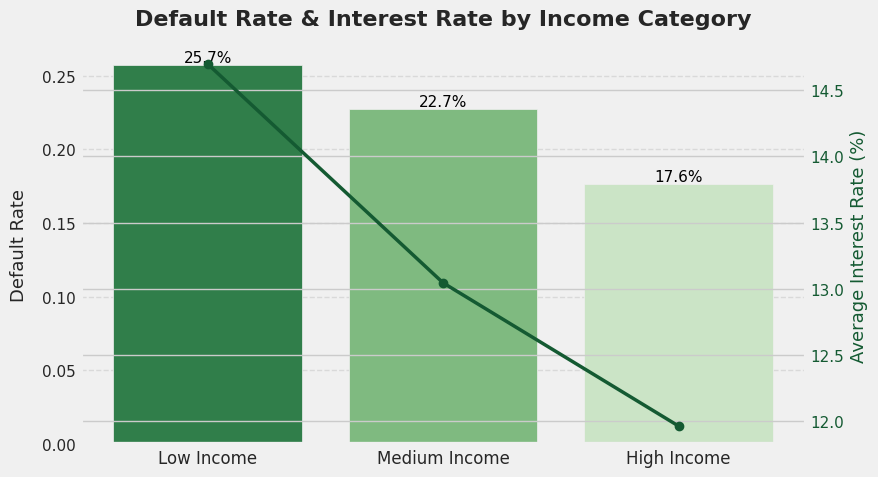

In [ ]:
beautiful_bar(df, 'Income_cat', 'Default Rate & Interest Rate by Income Category')

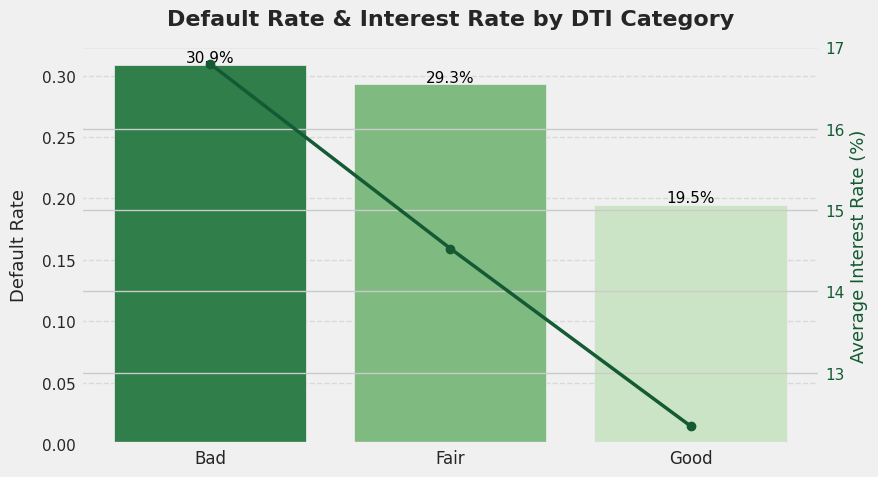

In [ ]:
beautiful_bar(df, 'DTI_cat', 'Default Rate & Interest Rate by DTI Category')

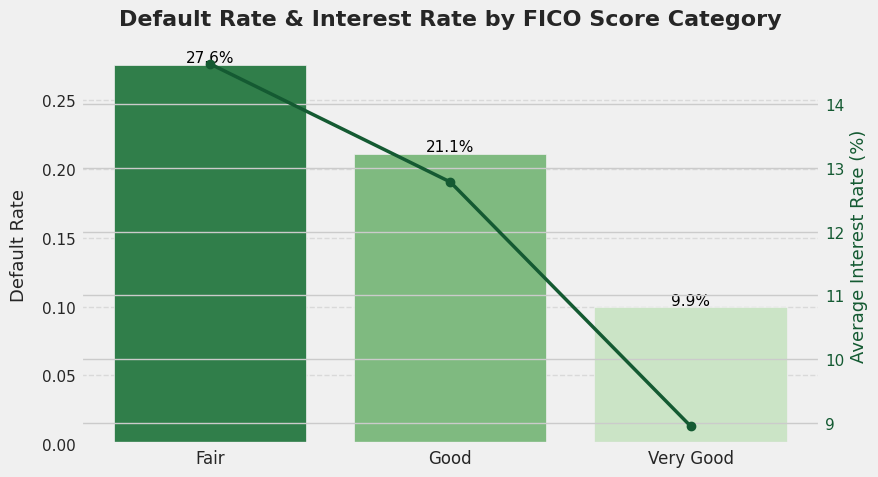

In [ ]:
beautiful_bar(df, 'FICO_cat', 'Default Rate & Interest Rate by FICO Score Category')

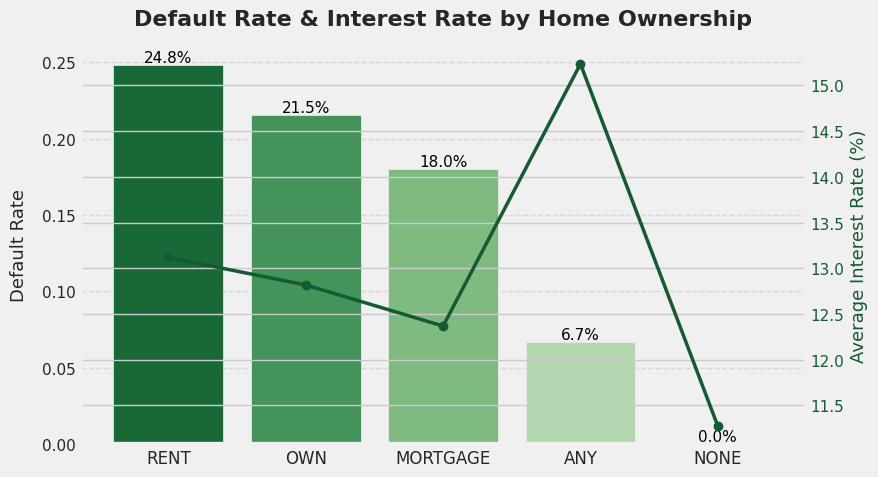

In [ ]:
beautiful_bar(df, 'home_ownership', 'Default Rate & Interest Rate by Home Ownership')

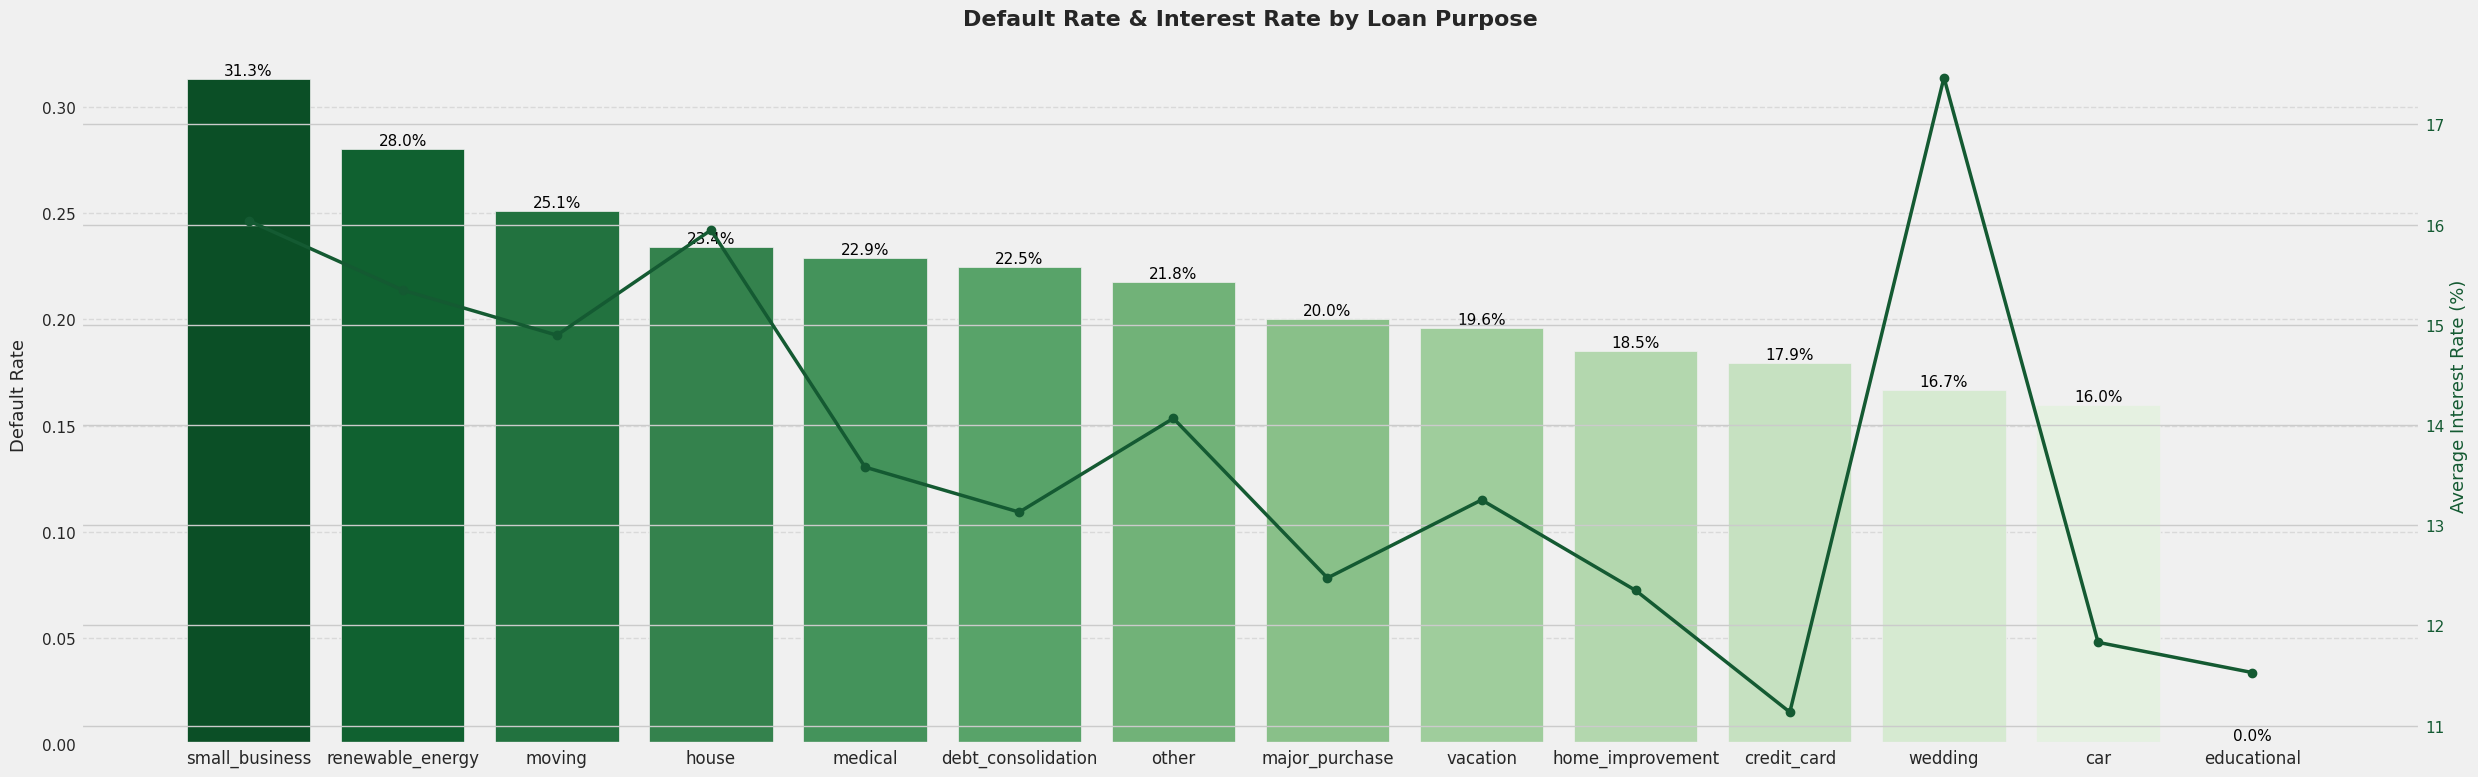

In [ ]:
# Temporarily enlarge only this one chart
old_fig = plt.figure  # backup original function
plt.figure = lambda *args, **kwargs: old_fig(figsize=(25, 8))  # force bigger size
beautiful_bar(df, 'purpose', 'Default Rate & Interest Rate by Loan Purpose')
plt.figure = old_fig


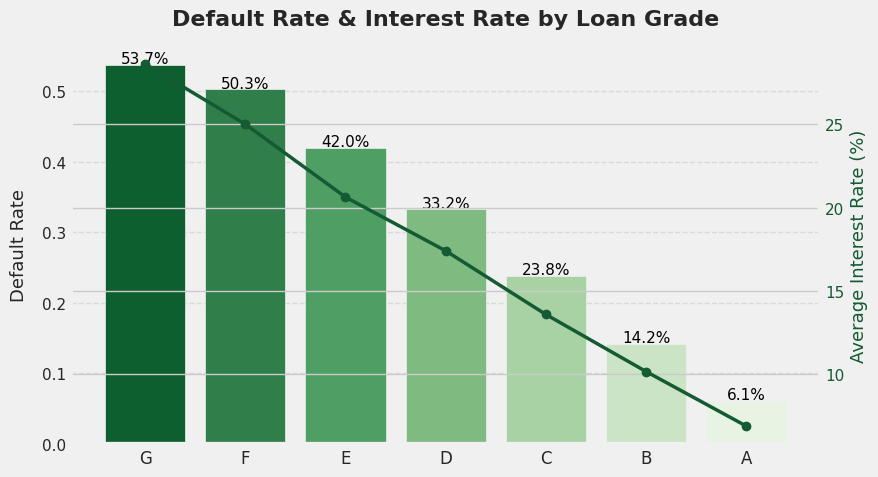

In [ ]:
beautiful_bar(df, 'grade', 'Default Rate & Interest Rate by Loan Grade')

In [ ]:
# Investment insights
print("Investment Insight:")
print("From the charts above, loans from High Income borrowers, Good/Very Good FICO scores, and Good DTI ratios show the lowest default rates.")
print("Although these loans offer slightly lower average interest rates, they represent safer, more stable investment opportunities.")
print("For an optimal balance, investing in Medium-to-High Income borrowers with Good credit quality provides both reliability and return potential.")

Investment Insight:
From the charts above, loans from High Income borrowers, Good/Very Good FICO scores, and Good DTI ratios show the lowest default rates.
Although these loans offer slightly lower average interest rates, they represent safer, more stable investment opportunities.
For an optimal balance, investing in Medium-to-High Income borrowers with Good credit quality provides both reliability and return potential.


##3) Machine Learning Models

###3.1)  OLS Regression

In [ ]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,default_dummy,Income_cat,DTI_cat,fico_mid,FICO_cat
0,66624733,18000,18000,18000.0,60 months,19.48,471.70,E,E2,Software Manager,7 years,RENT,150000.0,Not Verified,2015-12-01,Charged Off,n,debt_consolidation,Debt consolidation,916xx,CA,9.39,0,Jun-05,665,669,1,NaN,18,1,14052,40.7,27,w,0.0,0.0,9452.74,9452.74,3481.86,4351.98,0.00,1618.90,291.4020,May-17,471.70,NaN,Nov-17,584,580,0,NaN,1,Individual,NaN,NaN,NaN,0,60,36247,2.0,2.0,1.0,3.0,2.0,22195.0,71.0,2.0,4.0,1271.0,55.0,34500,2.0,1.0,2.0,7,2014.0,5128.0,51.3,0,0,115.0,112,1,1,2,9.0,NaN,2.0,NaN,0,6,13,7,8,6,16,19.0,13,18,0.0,0,0,3,100.0,14.3,1,0,65819,36247,10300,31319,N,Cash,N,1,High Income,Good,667.0,Fair
1,67849662,4225,4225,4225.0,36 months,14.85,146.16,C,C5,mechanic,5 years,RENT,35000.0,Source Verified,2015-12-01,Charged Off,n,debt_consolidation,Debt consolidation,672xx,KS,15.22,2,Jul-11,725,729,0,18.0,6,0,1058,24.6,6,w,0.0,0.0,2558.87,2558.87,1536.90,653.60,0.00,368.37,66.3066,Apr-17,146.16,NaN,Dec-17,499,0,0,NaN,1,Individual,NaN,NaN,NaN,0,0,4888,0.0,1.0,0.0,0.0,47.0,3830.0,22.0,0.0,0.0,367.0,22.0,4300,0.0,0.0,0.0,0,815.0,2233.0,14.1,0,0,47.0,53,26,26,0,26.0,NaN,14.0,18.0,0,1,2,3,3,1,5,5.0,2,6,0.0,0,0,0,66.7,0.0,0,0,21822,4888,2600,17522,N,Cash,N,1,Medium Income,Good,727.0,Good
2,67715283,16000,16000,16000.0,36 months,12.88,538.18,C,C2,"Owner, Fee Appraiser",10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,Charged Off,n,small_business,Business,354xx,AL,18.96,0,Dec-85,675,679,0,33.0,7,1,5157,54.3,20,w,0.0,0.0,17396.63,17396.63,13833.12,3402.05,161.46,0.00,0.0000,Nov-18,565.09,NaN,Mar-19,629,625,0,55.0,1,Individual,NaN,NaN,NaN,0,1830,39781,2.0,2.0,0.0,0.0,27.0,34624.0,68.0,2.0,2.0,739.0,64.0,9500,0.0,5.0,0.0,2,5683.0,3684.0,21.6,0,0,256.0,360,1,1,0,1.0,33.0,14.0,33.0,1,3,5,3,3,12,5,7.0,5,7,0.0,0,0,2,80.0,0.0,0,1,80999,39781,4700,71499,N,Cash,N,1,Medium Income,Good,677.0,Good
3,68341789,24250,24250,24250.0,60 months,24.24,701.01,F,F3,hvac technician,4 years,MORTGAGE,75000.0,Not Verified,2015-12-01,Charged Off,n,debt_consolidation,NaN,114xx,NY,20.84,0,Apr-07,660,664,0,NaN,18,0,24799,65.3,21,w,0.0,0.0,4124.42,4124.42,1332.69,2791.73,0.00,0.00,0.0000,Jul-16,701.01,NaN,Mar-18,499,0,0,NaN,1,Individual,NaN,NaN,NaN,0,0,320098,2.0,1.0,0.0,1.0,14.0,13676.0,75.0,2.0,10.0,3138.0,61.0,38000,1.0,1.0,3.0,13,17783.0,9044.0,68.9,0,0,93.0,104,2,2,2,2.0,NaN,7.0

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score

# --- 1. Feature Engineering ---
df['fraction_funded'] = df['funded_amnt_inv'] / df['loan_amnt']
df['pct_funded'] = (df['funded_amnt'] / df['loan_amnt']) * 100

# --- 2. Select predictors from Croux et al. (2020) ---
OLS_df = df[['default_dummy', 'loan_amnt', 'term', 'int_rate', 'installment',
             'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
             'annual_inc', 'verification_status', 'purpose', 'dti', 'open_acc',
             'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
             'application_type', 'mort_acc', 'pub_rec_bankruptcies',
             'addr_state', 'issue_d', 'earliest_cr_line',
             'fraction_funded', 'pct_funded']].copy()

# --- 3. Drop columns with >50% missing values ---
missing_pct = OLS_df.isnull().mean()
OLS_df = OLS_df[missing_pct[missing_pct <= 0.5].index]

# --- 4. Handle missing values ---
num_vars = OLS_df.select_dtypes(include=['number']).columns
cat_vars = OLS_df.select_dtypes(exclude=['number']).columns

num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

if len(num_vars) > 0:
    OLS_df[num_vars] = num_imputer.fit_transform(OLS_df[num_vars])
if len(cat_vars) > 0:
    OLS_df[cat_vars] = cat_imputer.fit_transform(OLS_df[cat_vars])

# --- 5. Format and simplify categorical variables ---
# Convert 'term' like '36 months' → numeric
if 'term' in OLS_df.columns:
    OLS_df['term'] = OLS_df['term'].astype(str).str.extract('(\d+)').astype(float)

# Convert 'emp_length' → binary (<10 yrs = 1, 10+ yrs = 0)
if 'emp_length' in OLS_df.columns:
    OLS_df['emp_length_below_10yrs'] = np.where(OLS_df['emp_length'] == '10+ years', 0, 1)
    OLS_df.drop(columns='emp_length', inplace=True, errors='ignore')

# Convert 'verification_status' → binary (1 = Not Verified)
if 'verification_status' in OLS_df.columns:
    OLS_df['status_not_verified'] = np.where(OLS_df['verification_status'] == 'Not Verified', 1, 0)
    OLS_df.drop(columns='verification_status', inplace=True, errors='ignore')

# Simplify 'sub_grade' → numeric rank
if 'sub_grade' in OLS_df.columns:
    grade_order = {g: i+1 for i, g in enumerate(sorted(OLS_df['sub_grade'].unique()))}
    OLS_df['sub_grade_num'] = OLS_df['sub_grade'].map(grade_order)
    OLS_df.drop(columns='sub_grade', inplace=True)

# Convert 'issue_d' and 'earliest_cr_line' → numeric credit age (months)
if {'issue_d', 'earliest_cr_line'}.issubset(OLS_df.columns):
    OLS_df['issue_d'] = pd.to_datetime(OLS_df['issue_d'], errors='coerce')
    OLS_df['earliest_cr_line'] = pd.to_datetime(OLS_df['earliest_cr_line'], errors='coerce')
    OLS_df['credit_age_months'] = (OLS_df['issue_d'] - OLS_df['earliest_cr_line']).dt.days / 30
    OLS_df.drop(columns=['issue_d', 'earliest_cr_line'], inplace=True)

# Drop free-text or ID-like columns that can't be encoded directly
OLS_df = OLS_df.drop(columns=['emp_title'], errors='ignore')

# --- 6. Dummy encode all remaining categoricals ---
OLS_df = pd.get_dummies(OLS_df, drop_first=True)

# --- 7. Define predictors and target ---
X = OLS_df.drop(columns='default_dummy', errors='ignore')
y = OLS_df['default_dummy']

# --- 8. Ensure all numeric and drop invalid rows ---
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')
X = X.loc[:, X.notna().all()]
X = X.dropna()
y = y.loc[X.index]

# --- 9. Add constant and fit OLS regression ---
X = sm.add_constant(X)
ols_model = sm.OLS(y.astype(float), X.astype(float)).fit()

# --- 10. Predict and evaluate ---
y_pred_prob = ols_model.predict(X)
y_pred_class = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y, y_pred_class)
accuracy = accuracy_score(y, y_pred_class)

# --- 11. Print results ---
print("="*70)
print("OLS Regression Model Summary")
print("="*70)
print(ols_model.summary())

print("\nConfusion Matrix:")
print(cm)
print(f"\nPrediction Accuracy: {accuracy:.4f}")

print(f"\nPredictors used: {X.shape[1]-1}")


<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:39: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3932663489.py:39: SyntaxWarning: invalid escape sequence '\d'
  OLS_df['term'] = OLS_df['term'].astype(str).str.extract('(\d+)').astype(float)


OLS Regression Model Summary
                            OLS Regression Results                            
Dep. Variable:          default_dummy   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     783.9
Date:                Tue, 04 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:10:08   Log-Likelihood:            -2.8613e+05
No. Observations:              611803   AIC:                         5.724e+05
Df Residuals:                  611711   BIC:                         5.735e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [ ]:
print("\nConfusion Matrix:")
print(cm)

print(f"\nPrediction Accuracy: {accuracy:.4f}")


Confusion Matrix:
[[475250   7345]
 [119445   9763]]

Prediction Accuracy: 0.7928


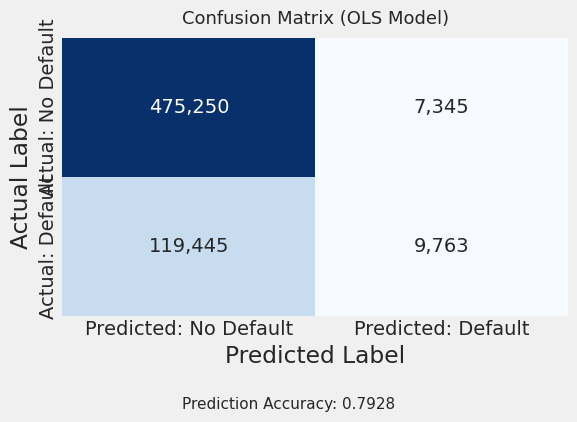

In [ ]:
# Confusion matrix values
cm_values = [[475250, 7345],
             [119445, 9763]]

# Create labeled DataFrame
cm_df = pd.DataFrame(cm_values,
                     index=['Actual: No Default', 'Actual: Default'],
                     columns=['Predicted: No Default', 'Predicted: Default'])

# Plot confusion matrix as table
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt=",.0f", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (OLS Model)", fontsize=13, pad=10)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")

# Add accuracy text below
plt.figtext(0.5, -0.05, f"Prediction Accuracy: {0.7928:.4f}",
            wrap=True, horizontalalignment='center', fontsize=11)

# Save as PNG
plt.tight_layout()
plt.savefig("OLS_Confusion_Matrix.png", dpi=300, bbox_inches='tight')
plt.show()


###3.2) Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Logistic Regression — Full Sample

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logit_full = LogisticRegression(random_state=42, max_iter=1000)
logit_full.fit(X_scaled, y)

y_pred_full = (logit_full.predict_proba(X_scaled)[:, 1] > 0.5).astype(int)
conf_matrix_full = confusion_matrix(y, y_pred_full)
accuracy_full = accuracy_score(y, y_pred_full)

print("Logistic Regression (Full Sample)")
print(pd.DataFrame(conf_matrix_full,
                   index=['Actual: Non-Default', 'Actual: Default'],
                   columns=['Predicted: Non-Default', 'Predicted: Default']))
print(f"\n Accuracy Rate: {accuracy_full:.4f}")

# Logistic Regression — 80/20 Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit = LogisticRegression(random_state=42, max_iter=1000)
logit.fit(X_train_scaled, y_train)

y_pred = (logit.predict_proba(X_test_scaled)[:, 1] > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\n Logistic Regression (80/20 Split)")
print(pd.DataFrame(conf_matrix,
                   index=['Actual: Non-Default', 'Actual: Default'],
                   columns=['Predicted: Non-Default', 'Predicted: Default']))
print(f"\n Accuracy Rate: {accuracy:.4f}")


Logistic Regression (Full Sample)
                     Predicted: Non-Default  Predicted: Default
Actual: Non-Default                  471606               10989
Actual: Default                      115272               13936

 Accuracy Rate: 0.7936

 Logistic Regression (80/20 Split)
                     Predicted: Non-Default  Predicted: Default
Actual: Non-Default                   94341                2178
Actual: Default                       23139                2703

 Accuracy Rate: 0.7931


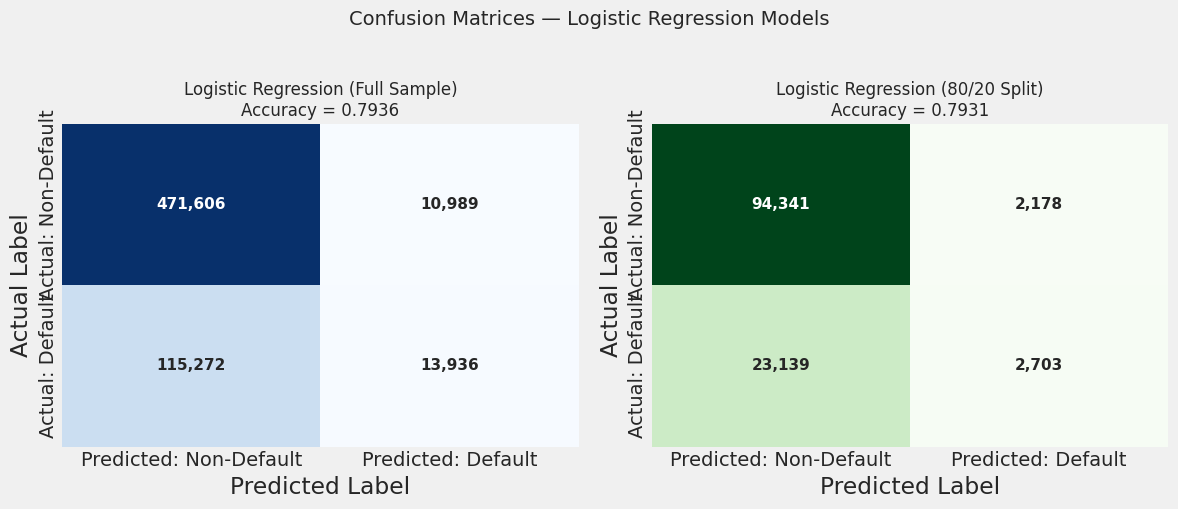

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# --- Logistic Regression — Full Sample ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logit_full = LogisticRegression(random_state=42, max_iter=1000)
logit_full.fit(X_scaled, y)

y_pred_full = (logit_full.predict_proba(X_scaled)[:, 1] > 0.5).astype(int)
conf_matrix_full = confusion_matrix(y, y_pred_full)
accuracy_full = accuracy_score(y, y_pred_full)

# --- Logistic Regression — 80/20 Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit = LogisticRegression(random_state=42, max_iter=1000)
logit.fit(X_train_scaled, y_train)

y_pred = (logit.predict_proba(X_test_scaled)[:, 1] > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# --- Create DataFrames for plotting ---
cm_full_df = pd.DataFrame(conf_matrix_full,
                          index=['Actual: Non-Default', 'Actual: Default'],
                          columns=['Predicted: Non-Default', 'Predicted: Default'])

cm_split_df = pd.DataFrame(conf_matrix,
                           index=['Actual: Non-Default', 'Actual: Default'],
                           columns=['Predicted: Non-Default', 'Predicted: Default'])

# --- Plot both confusion matrices side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Full sample confusion matrix
sns.heatmap(cm_full_df, annot=True, fmt=",.0f", cmap="Blues", cbar=False, ax=axes[0],
            annot_kws={"size": 11, "weight": "bold"})
axes[0].set_title(f"Logistic Regression (Full Sample)\nAccuracy = {accuracy_full:.4f}", fontsize=12)
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("Actual Label")

# 80/20 split confusion matrix
sns.heatmap(cm_split_df, annot=True, fmt=",.0f", cmap="Greens", cbar=False, ax=axes[1],
            annot_kws={"size": 11, "weight": "bold"})
axes[1].set_title(f"Logistic Regression (80/20 Split)\nAccuracy = {accuracy:.4f}", fontsize=12)
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("Actual Label")

# Add overall title and layout
plt.suptitle("Confusion Matrices — Logistic Regression Models", fontsize=14, y=1.02)
plt.tight_layout()

# Save figure
plt.savefig("Logistic_Regression_Confusion_Matrices.png", dpi=300, bbox_inches='tight')
plt.show()


###3.3) Ridge Regression

=== Ridge Regression (Classification) Results ===
   Lambda  Accuracy
    0.001  0.792352
    0.010  0.792352
    0.100  0.792360
    1.000  0.792368
   10.000  0.792426
  100.000  0.792426
 1000.000  0.792418
10000.000  0.792091

Best λ = 10.000  |  Accuracy = 0.79243


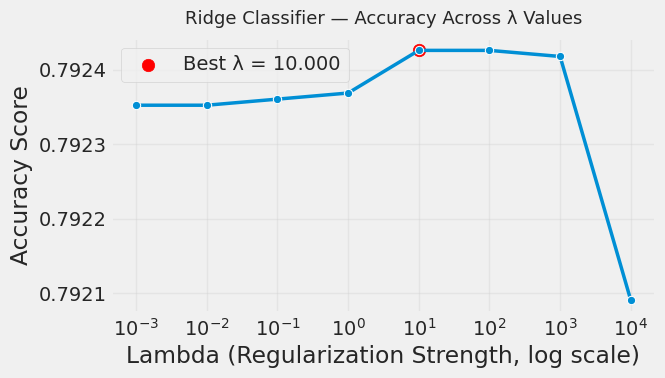

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Lambda values to test ---
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ridge_results = []

# --- Train Ridge Classifier for each λ ---
for lam in lambdas:
    ridge = RidgeClassifier(alpha=lam)
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    acc = accuracy_score(y_test, y_pred_ridge)
    ridge_results.append({'Lambda': lam, 'Accuracy': acc})

# --- Create DataFrame ---
ridge_results_df = pd.DataFrame(ridge_results)

# --- Identify best λ ---
best_row = ridge_results_df.loc[ridge_results_df['Accuracy'].idxmax()]

# --- Print Results ---
print("=== Ridge Regression (Classification) Results ===")
print(ridge_results_df.to_string(index=False))
print(f"\nBest λ = {best_row['Lambda']:.3f}  |  Accuracy = {best_row['Accuracy']:.5f}")

# --- Plot Accuracy vs Lambda ---
plt.figure(figsize=(7, 4))
sns.lineplot(x='Lambda', y='Accuracy', data=ridge_results_df, marker='o', linewidth=2.5)

# Highlight best point
plt.scatter(best_row['Lambda'], best_row['Accuracy'], color='red', s=80, label=f"Best λ = {best_row['Lambda']:.3f}")

# Log-scale for better spacing
plt.xscale('log')

# Labels and title
plt.title("Ridge Classifier — Accuracy Across λ Values", fontsize=13, pad=10)
plt.xlabel("Lambda (Regularization Strength, log scale)")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid(alpha=0.3)

# Save and show
plt.tight_layout()
plt.savefig("Ridge_Classifier_Accuracy_vs_Lambda.png", dpi=300, bbox_inches='tight')
plt.show()


 ### 3.4) Lasso Regression

=== Lasso Logistic Regression (Full Sample) ===
   Lambda  Accuracy
    0.001  0.793540
    0.010  0.793541
    0.100  0.793538
    1.000  0.793566
   10.000  0.793479
  100.000  0.793366
 1000.000  0.792378
10000.000  0.791245

Best λ = 1.000  |  Accuracy = 0.7936


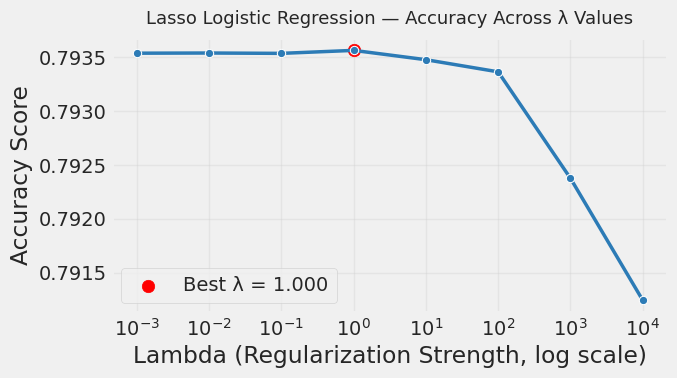

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- Lambda (λ) values to test ---
lambdas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
C_values = [1 / lam for lam in lambdas]  # C = 1/λ

lasso_results = []

# --- Train Logistic Regression with L1 penalty for each λ ---
for lam, C in zip(lambdas, C_values):
    lasso = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        C=C,
        max_iter=1000,
        random_state=42
    )
    lasso.fit(X, y)
    y_pred_lasso = lasso.predict(X)
    acc = accuracy_score(y, y_pred_lasso)
    lasso_results.append({'Lambda': lam, 'Accuracy': acc})

# --- Create results DataFrame ---
lasso_results_df = pd.DataFrame(lasso_results)

# --- Identify best λ ---
best_row = lasso_results_df.loc[lasso_results_df['Accuracy'].idxmax()]

# --- Print table ---
print("=== Lasso Logistic Regression (Full Sample) ===")
print(lasso_results_df.to_string(index=False))
print(f"\nBest λ = {best_row['Lambda']:.3f}  |  Accuracy = {best_row['Accuracy']:.4f}")

# --- Plot Accuracy vs Lambda ---
plt.figure(figsize=(7, 4))
sns.lineplot(x='Lambda', y='Accuracy', data=lasso_results_df, marker='o', linewidth=2.5, color="#2C7BB6")

# Highlight best λ
plt.scatter(best_row['Lambda'], best_row['Accuracy'], color='red', s=80,
            label=f"Best λ = {best_row['Lambda']:.3f}")

# Log scale for λ
plt.xscale('log')

# Add labels, title, grid
plt.title("Lasso Logistic Regression — Accuracy Across λ Values", fontsize=13, pad=10)
plt.xlabel("Lambda (Regularization Strength, log scale)")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid(alpha=0.3)

# Save and show
plt.tight_layout()
plt.savefig("Lasso_Logistic_Accuracy_vs_Lambda.png", dpi=300, bbox_inches='tight')
plt.show()


## 4) Open-Ended Extension

### Optimal Investment Threshold — Highest Expected Return

=== Optimal Investment Threshold ===
τ* = 0.68
Invested Loans = 122249
Total Expected Profit = $80,619,199.13
Average ROI = 0.1996
Realized Default Rate = 0.2108


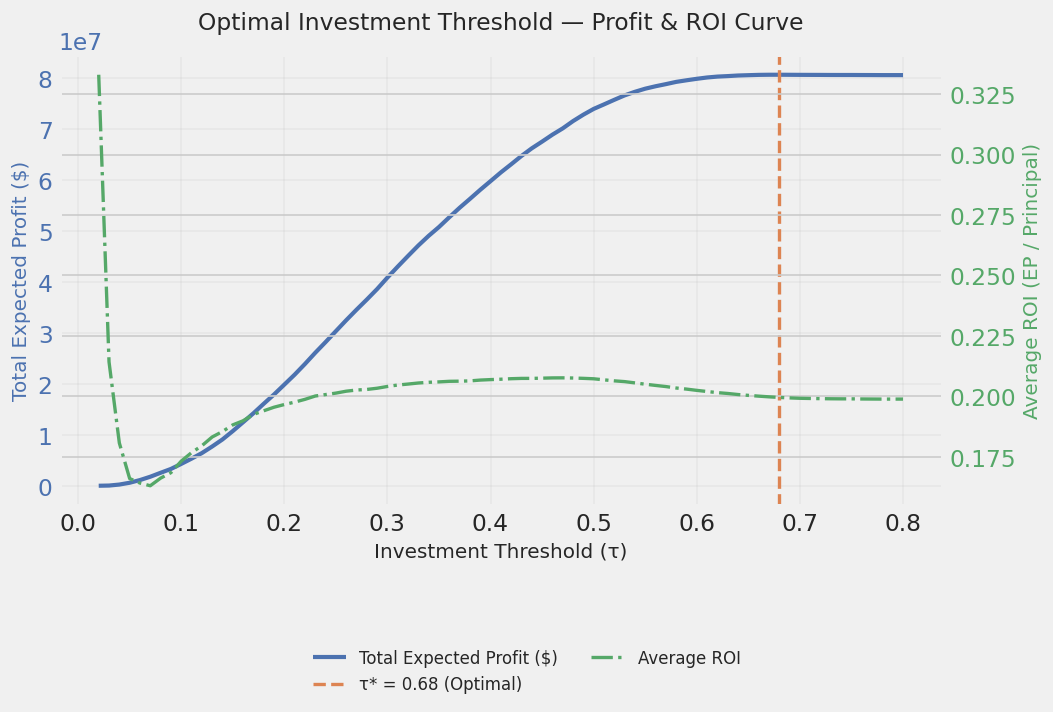

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
plt.style.use('seaborn-v0_8-muted')  # soft modern color theme

# --- Split & scale (if not already done) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Train logistic regression ---
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# --- Predict probabilities ---
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# --- Parameters ---
LGD = 0.60   # 60% loss given default
FEE = 0.01   # 1% servicing/platform fee

# --- Build test DataFrame safely ---
test_df = pd.DataFrame({"actual_default": y_test})
test_df["loan_amnt"] = df["loan_amnt"].iloc[:len(test_df)].astype(float)
test_df["int_rate_num"] = (
    df["int_rate"].iloc[:len(test_df)].astype(str)
    .str.replace("%", "", regex=False)
    .astype(float)
    / 100
)
test_df["term_m"] = (
    df["term"].iloc[:len(test_df)]
    .astype(str)
    .str.extract(r"(\d+)")[0]
    .astype(float)
    .fillna(36)
)

# --- Expected profit per loan ---
principal = test_df["loan_amnt"]
years = test_df["term_m"] / 12
exp_interest = test_df["int_rate_num"] * years * principal
exp_loss = LGD * principal
exp_fee = FEE * principal

EP = (1 - y_proba) * exp_interest - y_proba * exp_loss - exp_fee
ROI = EP / principal.replace(0, np.nan)

# --- Sweep thresholds to find τ* maximizing total profit ---
thresholds = np.arange(0.02, 0.81, 0.01)
rows = []
for t in thresholds:
    invest = y_proba <= t
    if invest.sum() == 0:
        continue
    total_profit = EP[invest].sum()
    avg_roi = ROI[invest].mean()
    realized_def = test_df.loc[invest, "actual_default"].mean()
    rows.append([t, invest.sum(), total_profit, avg_roi, realized_def])

thr_df = pd.DataFrame(rows, columns=["threshold", "n_invest", "total_profit", "avg_ROI", "realized_default"])
best = thr_df.loc[thr_df["total_profit"].idxmax()]

# --- Print key results ---
print("=== Optimal Investment Threshold ===")
print(f"τ* = {best.threshold:.2f}")
print(f"Invested Loans = {int(best.n_invest)}")
print(f"Total Expected Profit = ${best.total_profit:,.2f}")
print(f"Average ROI = {best.avg_ROI:.4f}")
print(f"Realized Default Rate = {best.realized_default:.4f}")

# --- Visualization Section ---
fig, ax1 = plt.subplots(figsize=(9, 5), dpi=120)

# Profit curve
ax1.plot(thr_df["threshold"], thr_df["total_profit"],
         color="#4C72B0", linewidth=2.5, label="Total Expected Profit ($)")
ax1.axvline(best["threshold"], color="#DD8452", linestyle="--", linewidth=2,
            label=f"τ* = {best.threshold:.2f} (Optimal)")
ax1.set_xlabel("Investment Threshold (τ)", fontsize=12)
ax1.set_ylabel("Total Expected Profit ($)", color="#4C72B0", fontsize=12)
ax1.tick_params(axis='y', labelcolor="#4C72B0")
ax1.grid(alpha=0.25)

# ROI on secondary axis
ax2 = ax1.twinx()
ax2.plot(thr_df["threshold"], thr_df["avg_ROI"],
         color="#55A868", linewidth=2, linestyle="-.", label="Average ROI")
ax2.set_ylabel("Average ROI (EP / Principal)", color="#55A868", fontsize=12)
ax2.tick_params(axis='y', labelcolor="#55A868")

# Title and legend
plt.title("Optimal Investment Threshold — Profit & ROI Curve", fontsize=14, pad=15)
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2, fontsize=10, frameon=False)
plt.tight_layout()
plt.show()
